<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Report
</div>


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Download train and val dataset
!wget -q -O report_train.npy "https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1"
!wget -q -O report_val.npy "https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"

## A. Data Loading and Preprocessing

In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

# Load Dataset
x_train = np.transpose(np.load('report_train.npy'), (0, 3, 1, 2))
x_val = np.transpose(np.load('report_val.npy'), (0, 3, 1, 2))

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')

num_classes = 6

# Create labels
y_train = np.concatenate([np.full(425, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(100, i) for i in range(num_classes)])

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

Shape of x_train: (2550, 3, 150, 150)
Shape of x_val: (600, 3, 150, 150)


In [17]:
batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Number of samples in train and validation are 2550 and 600.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


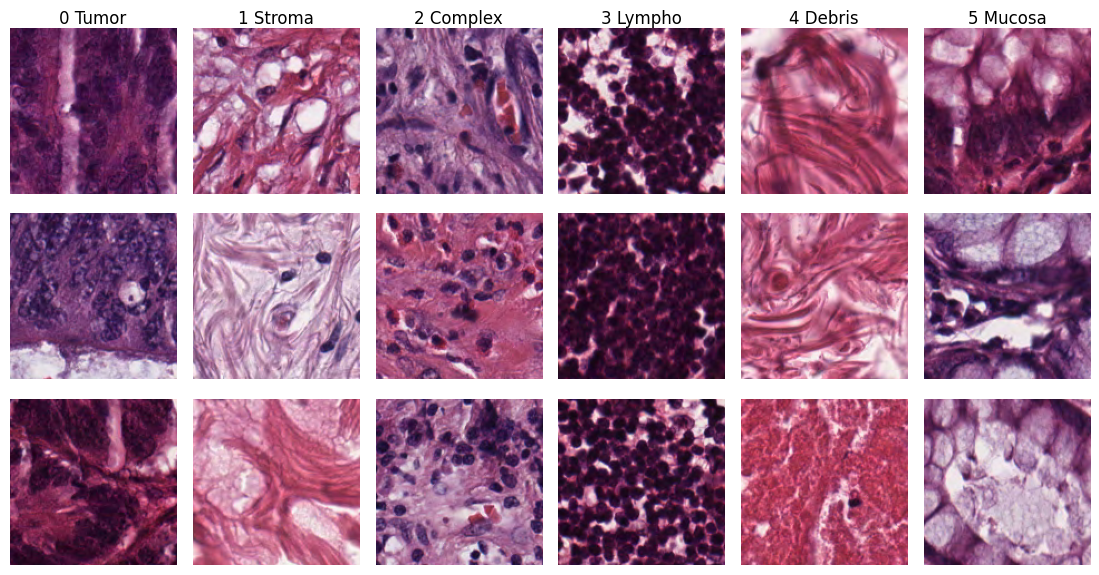

In [18]:
import matplotlib.pyplot as plt
import random

class_names = ['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa']

num_classes = 6
samples_per_class = 3

fig, axes = plt.subplots(samples_per_class, num_classes, figsize=(12, 6))

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

for class_idx in range(num_classes):
    indices_of_class = np.where(y_train == class_idx)[0]
    random_indices = random.sample(list(indices_of_class), samples_per_class)

    for i in range(samples_per_class):
        ax = axes[i, class_idx]
        img = x_train[random_indices[i]].numpy().transpose((1, 2, 0))
        img = img / img.max()
        ax.imshow(img)
        ax.axis('off')

        if i == 0:
            ax.set_title(f'{class_idx} {class_names[class_idx]}', pad=3)

plt.show()

In [19]:
import os
import json
import torch
import matplotlib.pyplot as plt

class ModelData():

    def __init__(self, name, dataset_name):
        ''' 使用範例:
            md_data = ModelData(name="Model", dataset_name=[""])
            md_data.model_path="/content/drive"
            md_data.add_data(epoch=0, loss=0.5)
            md_data.reset_data(time=str(datetime.datetime.now()))
            md_data.save_data()
        '''
        self.model_data_dic = {}
        self.reset_data(name=name, dataset_name=dataset_name)
        self.model_path = "."

    def reset_path_and_folder(self, model_path):
        os.makedirs(model_path, exist_ok=True)
        self.model_path = model_path

    def reset_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)  # 設置實例的屬性
            self.model_data_dic[kwarg] = value  # 更新 self.model_data_dic 字典

    def add_data(self, **kwargs):
        for kwarg, value in kwargs.items():
            setattr(self, kwarg, value)
            if kwarg in self.model_data_dic and isinstance(self.model_data_dic[kwarg], list):
                self.model_data_dic[kwarg].append(value)
            else:
                self.model_data_dic[kwarg] = [value]

    def save_data(self, path=None, name=None):
        if path is None:
            path = self.model_path
        if name is None:
            name = self.name

        # 確保目錄存在，如果不存在則創建
        os.makedirs(path, exist_ok=True)

        file_path = f"{path}/{name}.json"
        existing_model_list = []

        if os.path.exists(file_path):
            with open(file_path, 'r') as f:
                existing_model_list = json.load(f)

        existing_model_list.append(self.model_data_dic)

        with open(file_path, 'w') as f:
            json.dump(existing_model_list, f, indent=4)

        print(f"Successfully dumped data into {file_path}")

    def read_data(self, model_name_list, model_root_path, mode="wm"):
        existing_model_list = []
        weight_list = []

        for name in model_name_list:
            if not name:  # Skip empty names
                continue

            file_path = f"{model_root_path}/{name}/{name}.json"  # 使用 model_root_path
            weight_path = f"{model_root_path}/{name}/{name}.pth"  # 使用 model_root_path

            print(f"Trying to read JSON from: {file_path}")  # 調試信息
            print(f"Trying to read weights from: {weight_path}")  # 調試信息

            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    existing_model_list.append(json.load(f))
            else:
                print(f"File {file_path} does not exist.")

            if os.path.exists(weight_path):
                weight_list.append(torch.load(weight_path))
            else:
                print(f"Weight file {weight_path} does not exist.")

        if mode == "w":
            return weight_list
        if mode == "m":
            return existing_model_list
        else:
            return weight_list, existing_model_list

    def compare_images(self, existing_model_list):
        for model_data in existing_model_list:
            for each_model_data in model_data:
                fig, ax = plt.subplots(1, 2, figsize=(15, 5))

                # Plotting training and validation accuracy
                ax[0].plot(each_model_data["train_accuracies"])
                ax[0].plot(each_model_data["val_accuracies"])
                ax[0].set_title(f'{each_model_data["name"]} Accuracy')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Accuracy')
                ax[0].legend(['Train', 'Val'])

                # Plotting training and validation loss
                ax[1].plot(each_model_data["train_losses"])
                ax[1].plot(each_model_data["val_losses"])
                ax[1].set_title(f'{each_model_data["name"]} Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Loss')
                ax[1].legend(['Train', 'Val'])

                plt.show()

    def change_data(self, data_path, key, value):
        if os.path.exists(data_path):
            # 讀取現有的數據
            with open(data_path, 'r') as f:
                total_data = json.load(f)

            # 修改數據
            for i in total_data:
                i[key] = value

            # 寫回文件
            with open(data_path, 'w') as f:
                json.dump(total_data, f, indent=4)

In [20]:
try:
    import einops
except:
    !pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.8 MB/s eta 0:00:00


In [21]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


class Image2Tokens(nn.Module):
    def __init__(self, image_size, dim, in_dim=1, patch_size=15, emb_dropout=0.):
        super().__init__()
        image_height, image_width = image_size
        num_patches = (image_height // patch_size) * (image_width // patch_size)
        patch_dim = in_dim * patch_size * patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, dim),
        )
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        return self.dropout(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(dim, dim*3)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        dots = (q @ k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


class FeedForwardNetwork(nn.Module):
    def __init__(self, dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim*4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim*4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class Transformer(nn.Module):
    def __init__(self, layers, dim, heads=8, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(layers):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads=heads, dropout=dropout)),
                PreNorm(dim, FeedForwardNetwork(dim, dropout=dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class ViT(nn.Module):
    def __init__(self, layers, dim, heads, image_size, num_classes, patch_size=16, in_dim=3, dropout=0., emb_dropout=0.):
        super().__init__()
        self.tokenizer = Image2Tokens(image_size=image_size, dim=dim, in_dim=in_dim, patch_size=patch_size, emb_dropout=emb_dropout)
        self.transformer = Transformer(layers=layers, dim=dim, heads=heads, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        out = self.tokenizer(img)
        out = self.transformer(out)
        out = out[:, 0]
        return self.classifier(out)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same') # 150*150
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 75*75

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 75*75
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 37*37

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 37*37
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 18*18

        flattened_dim = 18 * 18 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 6)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# # 1st model: ResNet18
# model = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# # 2nd model: AlexNet
# model = models.alexnet(weights='IMAGENET1K_V1')
# num_ftrs = model.classifier[6].in_features
# model.classifier[6] = nn.Linear(num_ftrs, num_classes)

# 3rd model: Inception v1
# model = models.googlenet(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)

# 4th model: DenseNet121
# model = models.densenet121(weights='IMAGENET1K_V1')
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, num_classes)

# # # 5th model: ResNet50
# model = models.resnet50(weights='IMAGENET1K_V1')
# num_ftrs_resnet50 = model.fc.in_features
# model.fc = nn.Linear(num_ftrs_resnet50, num_classes)


# # 6th model: EfficientNetB4
# from torchvision.models import EfficientNet_B4_Weights
# from torchvision.models._api import WeightsEnum
# from torch.hub import load_state_dict_from_url

# def get_state_dict(self, *args, **kwargs):
#     kwargs.pop("check_hash")
#     return load_state_dict_from_url(self.url, *args, **kwargs)
# WeightsEnum.get_state_dict = get_state_dict

# model = models.efficientnet_b4(weights=EfficientNet_B4_Weights.IMAGENET1K_V1)
# num_ftrs_efficientnetb4 = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_ftrs_efficientnetb4, num_classes)

model = model.cuda()
print(model)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 106MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## B. Defining Neural Networks

In [34]:
md_data = ModelData(name="ViT_patch_30", dataset_name=["https://www.dropbox.com/scl/fi/30dlbblp7wytcvoy05col/report_train.npy?rlkey=jx100qoz5n1d654v2mi32i9aj&dl=1","https://www.dropbox.com/scl/fi/oo6g1yqhbjm22wffeddgv/report_val.npy?rlkey=9rqe0rucjhrbzv3x7xbs5047z&dl=1"])
md_data.reset_path_and_folder(f"/content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/{md_data.name}")

import datetime
traning_times = []

In [38]:
model = ViT(layers=9, dim=192, heads=12, image_size=(150, 150), num_classes=6, patch_size=30, in_dim=3, dropout=0., emb_dropout=0.)
# model = ConvModel()
model.cuda()

ViT(
  (tokenizer): Image2Tokens(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=30, p2=30)
      (1): Linear(in_features=2700, out_features=192, bias=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-8): 9 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=192, out_features=576, bias=True)
            (to_out): Sequential(
              (0): Linear(in_features=192, out_features=192, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForwardNetwork(
            (net): Sequential(
              (0): Linear(in_features=192, out_features=768,

## C. Training the Neural Network

In [30]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), f'{md_data.model_path}/{md_data.name}.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    training_time = str(datetime.datetime.now())
    traning_times.append(training_time)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 1.6674, Train acc: 27.53%, Val loss: 1.3791, Val acc: 37.83%, Best Val loss: 1.3791 Best Val acc: 37.83%
Epoch 2/30, Train loss: 1.1874, Train acc: 44.67%, Val loss: 1.0203, Val acc: 51.33%, Best Val loss: 1.0203 Best Val acc: 51.33%
Epoch 3/30, Train loss: 0.9328, Train acc: 60.51%, Val loss: 0.9927, Val acc: 57.67%, Best Val loss: 0.9927 Best Val acc: 57.67%
Epoch 4/30, Train loss: 0.8907, Train acc: 62.75%, Val loss: 0.8109, Val acc: 66.00%, Best Val loss: 0.8109 Best Val acc: 66.00%
Epoch 5/30, Train loss: 0.8334, Train acc: 65.22%, Val loss: 0.7757, Val acc: 64.67%, Best Val loss: 0.7757 Best Val acc: 66.00%
Epoch 6/30, Train loss: 0.8045, Train acc: 65.49%, Val loss: 0.8473, Val acc: 63.00%, Best Val loss: 0.7757 Best Val acc: 66.00%
Epoch 7/30, Train loss: 0.7593, Train acc: 68.12%, Val loss: 0.8248, Val acc: 66.17%, Best Val loss: 0.7757 Best Val acc: 66.17%
Epoch 8/30, Train loss: 0.7305, Train acc: 70.12%, Val loss: 0.7238, Val acc: 68.67%, Best Val lo

### Visualizing model performance

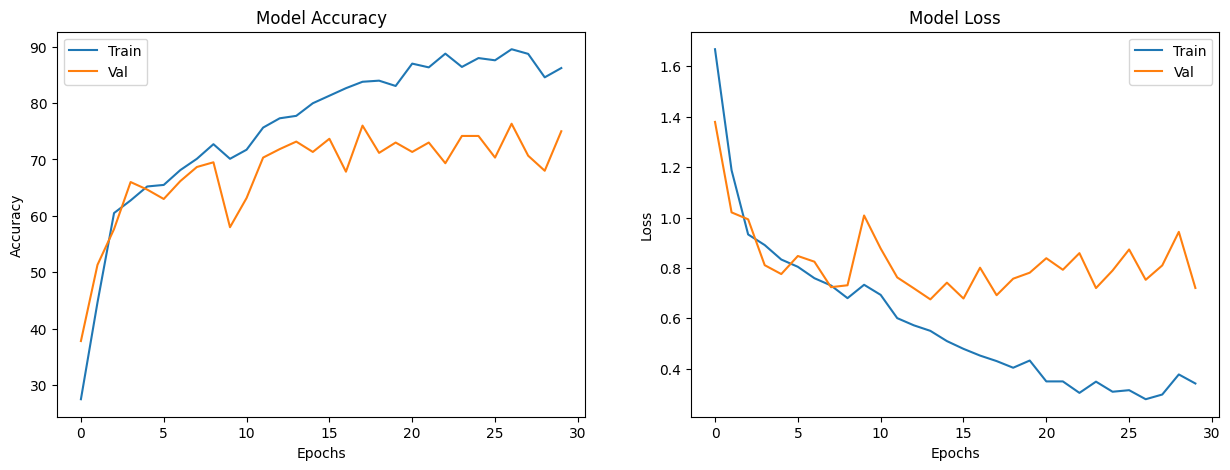

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Process Test Dataset

In [35]:
# Download test dataset,
!wget -q -O report_test.npy "https://www.dropbox.com/scl/fi/ufcagx2cvjmervgqrgwrt/report_test.npy?rlkey=fijueom5x54628ivpzeki2bt0&dl=1"

In [36]:
x_test = np.transpose(np.load('report_test.npy'), (0, 3, 1, 2))
print(f'Shape of x_test: {x_test.shape}')

y_test = np.concatenate([np.full(100, i) for i in range(num_classes)])

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

print(f'x_test: max value is {x_test.max().item()}, min value is {x_test.min().item()}, data type is {x_test.dtype}.')

batch_size = 32

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

Shape of x_test: (600, 3, 150, 150)
x_test: max value is 255.0, min value is 0.0, data type is torch.float32.


### Load Trained Model and Evaluate

In [39]:
# Load the trained weights
model.load_state_dict(torch.load(f'{md_data.model_path}/{md_data.name}.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
total_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        predicted = outputs.argmax(-1)
        test_correct += (predicted.float() == labels).sum().item()
        test_total += labels.size(0)

test_avg_loss = total_loss / len(test_loader)
test_accuracy = 100. * test_correct / test_total

print(f'test_avg_loss: {test_avg_loss}')
print(f'Test accuracy is {test_accuracy}%.')

test_avg_loss: 0.6674077232417307
Test accuracy is 77.66666666666667%.


In [40]:
md_data.reset_data(train_losses=train_losses, val_losses=val_losses, train_accuracies=train_accuracies, val_accuracies=val_accuracies, traning_times=traning_times)
md_data.reset_data(model=str(model))
md_data.reset_data(test_data=["https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy","https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy"])
md_data.reset_data(test_avg_loss=test_avg_loss, test_accuracy=test_accuracy)
md_data.save_data()

Successfully dumped data into /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ViT_patch_30/ViT_patch_30.json


Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ViT/ViT.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ViT/ViT.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ViT_patch_15/ViT_patch_15.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ViT_patch_15/ViT_patch_15.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ConvModel/ConvModel.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ConvModel/ConvModel.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ResNet18/ResNet18.json
Trying to read weights from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/ResNet18/ResNet18.pth
Trying to read JSON from: /content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model/AlexNet/AlexNet.json
Tryi

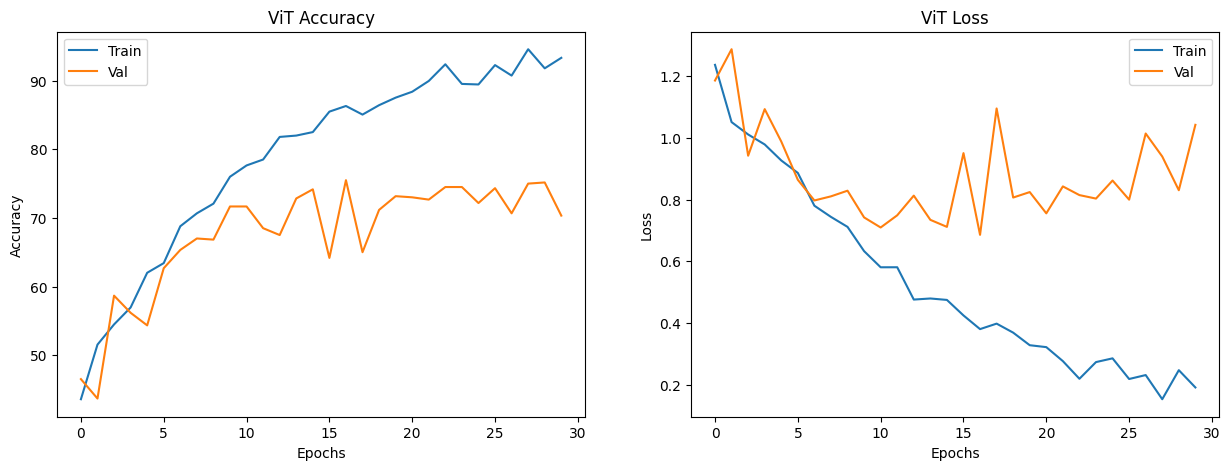

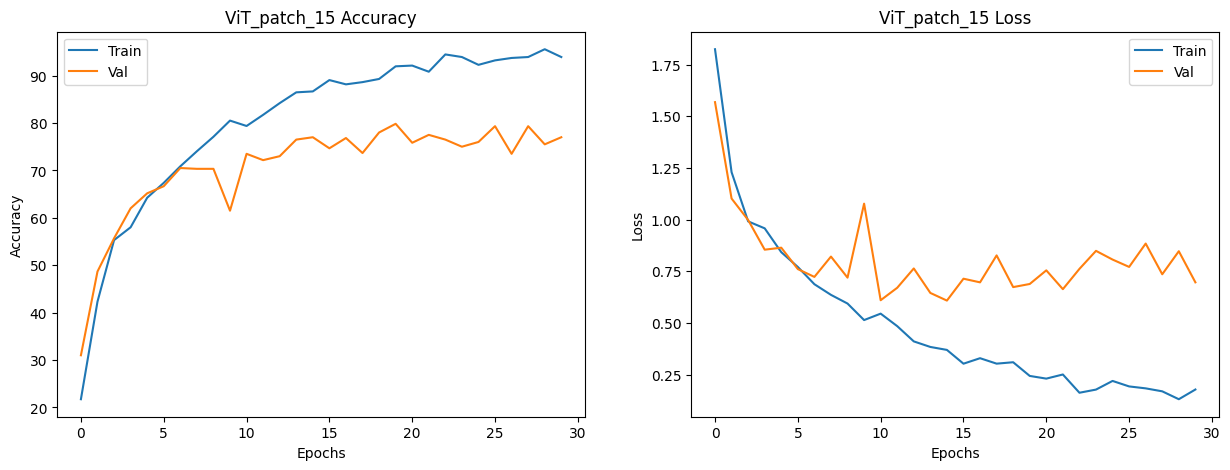

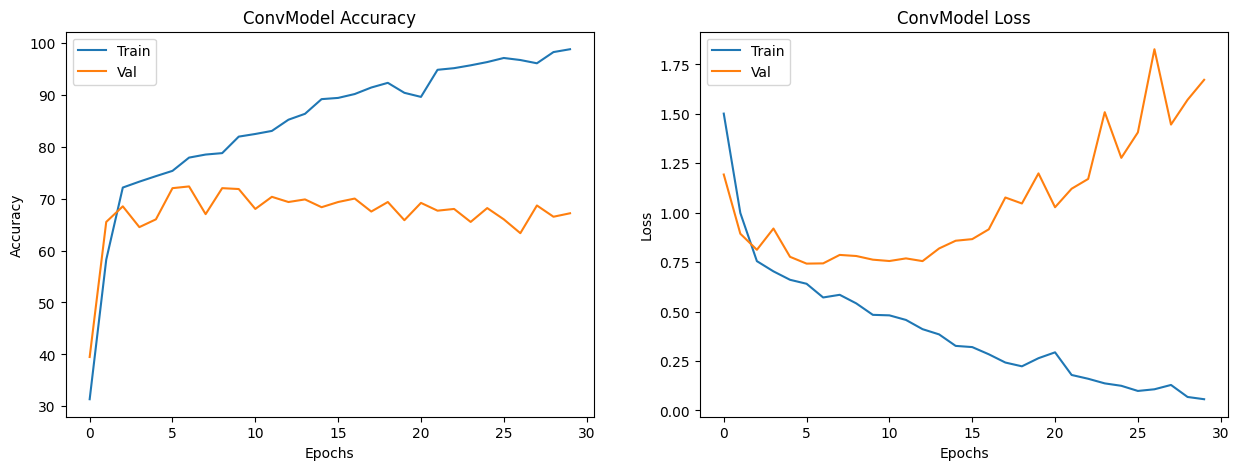

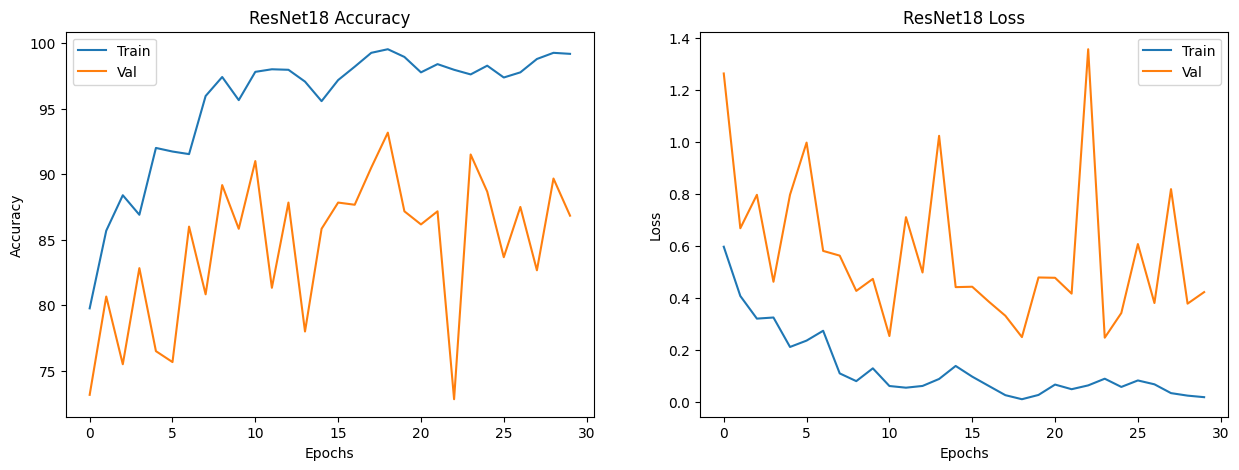

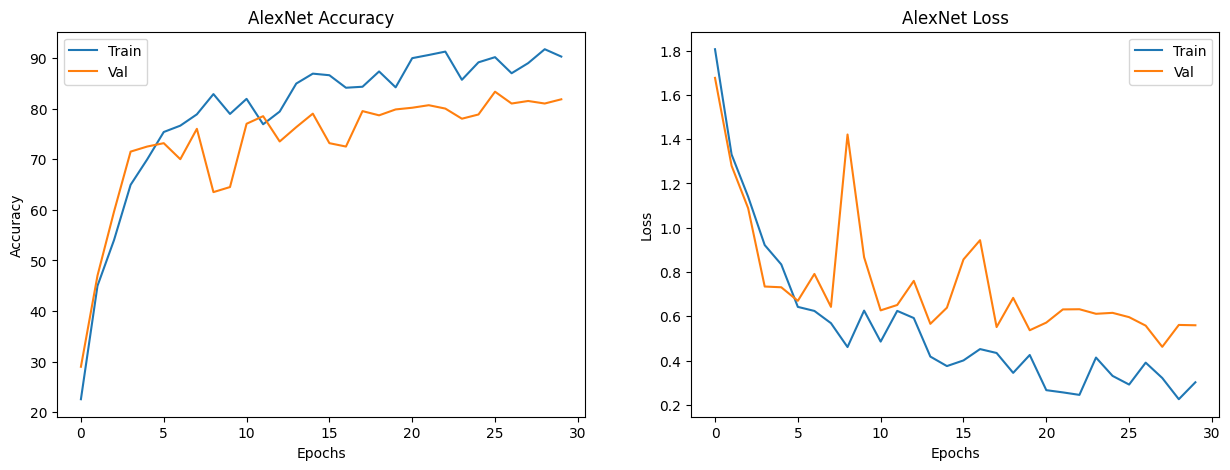

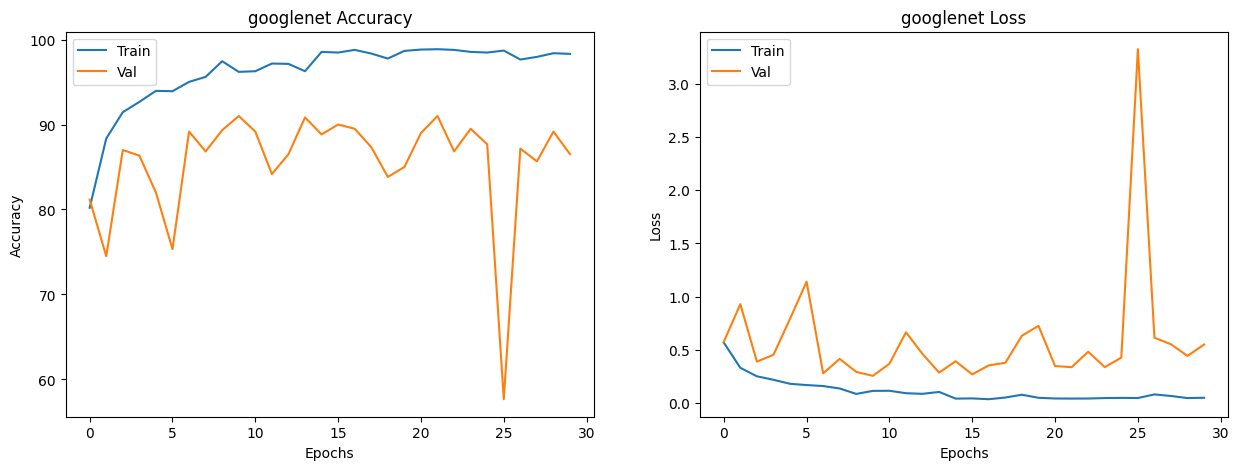

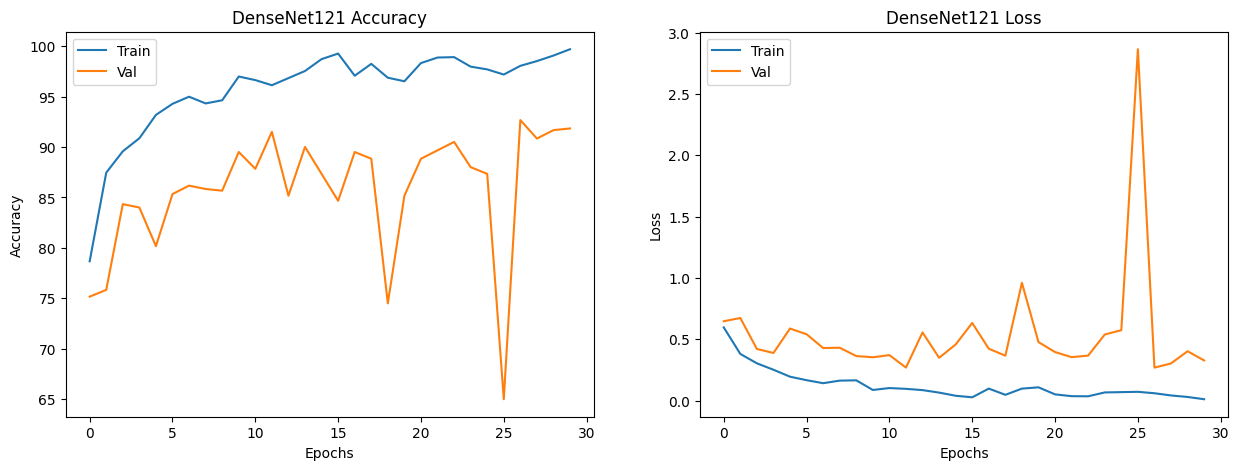

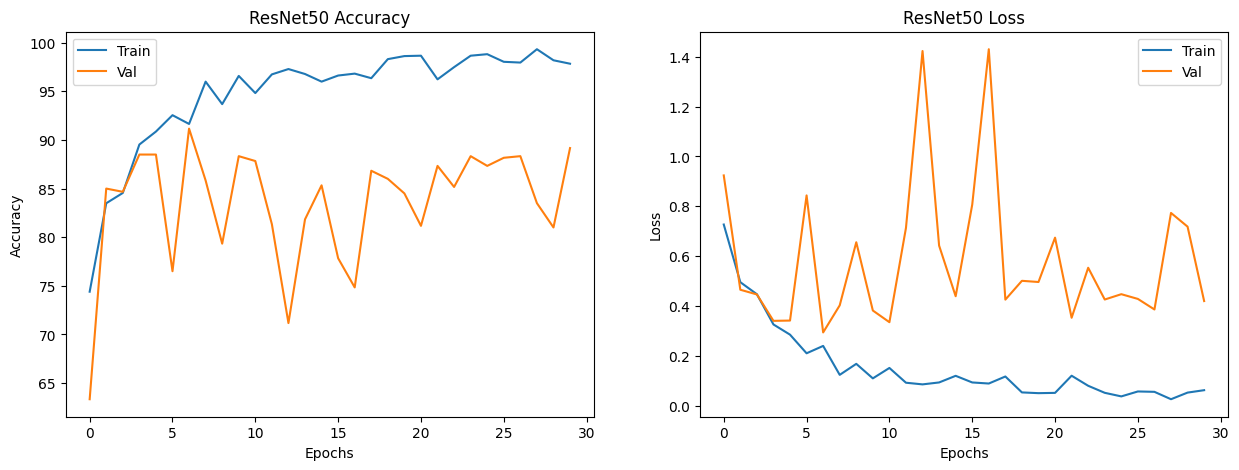

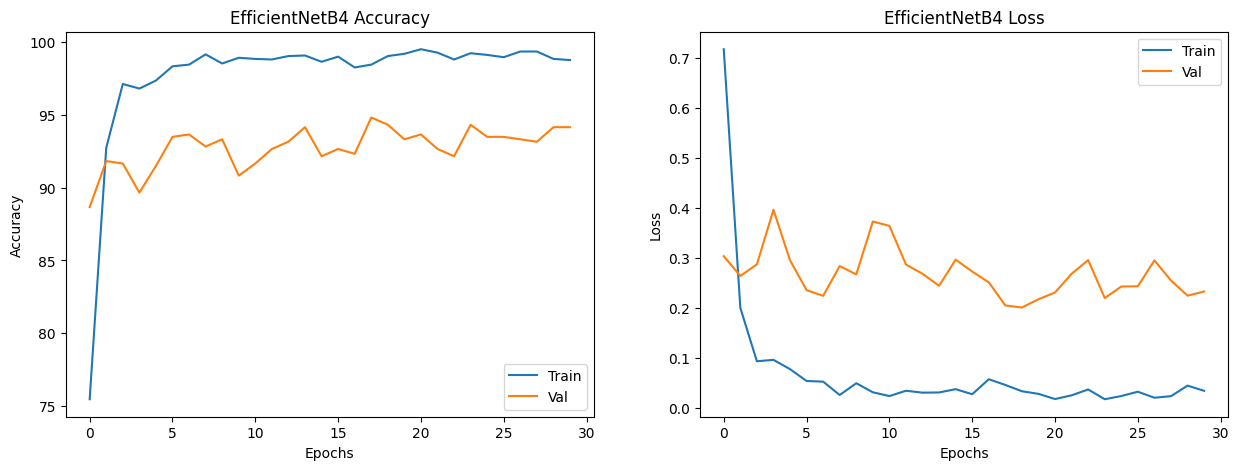

In [ ]:
model_name_list = ['ViT','ViT_patch_15','ConvModel','ResNet18', 'AlexNet', 'googlenet', 'DenseNet121', 'ResNet50', 'EfficientNetB4']

model_root_path = "/content/drive/MyDrive/Course/研一上/深度學習之於生醫/self-report/Model"
weight_list, existing_model_list = md_data.read_data(model_name_list, model_root_path, mode="wm")
md_data.compare_images(existing_model_list)

In [ ]:
for mds in existing_model_list:
    for md in mds:
        print(f"{md['name']} ")
        print(f"test_avg_loss is {round(md['test_avg_loss'],3)}")
        print(f"test_accuracy is {round(md['test_accuracy'],3)}")
        start_time = datetime.datetime.fromisoformat(md['traning_times'][0])
        end_time = datetime.datetime.fromisoformat(md['traning_times'][-1])
        duration = end_time - start_time
        # minutes, seconds = divmod(duration.seconds, 60)
        # formatted_duration = f"{minutes}分{seconds}秒"
        # print(f"{formatted_duration}")
        total_seconds = round(duration.total_seconds(),1)
        print(total_seconds,"秒")

        accuracy_per_second = round(md['test_accuracy'] / total_seconds, 5)
        print(f"Accuracy per Second: {accuracy_per_second}","%")

        loss_per_second = round(md['test_avg_loss'] / total_seconds, 5)
        print(f"Loss per Second: {loss_per_second}")

ViT 
test_avg_loss is 0.683
test_accuracy is 75.333
359.7 秒
Accuracy per Second: 0.20943 %
Loss per Second: 0.0019
ViT_patch_15 
test_avg_loss is 0.633
test_accuracy is 79.5
129.9 秒
Accuracy per Second: 0.61201 %
Loss per Second: 0.00487
ConvModel 
test_avg_loss is 0.709
test_accuracy is 74.667
52.8 秒
Accuracy per Second: 1.41414 %
Loss per Second: 0.01342
ResNet18 
test_avg_loss is 0.307
test_accuracy is 93.0
148.5 秒
Accuracy per Second: 0.62626 %
Loss per Second: 0.00207
AlexNet 
test_avg_loss is 0.543
test_accuracy is 85.0
95.5 秒
Accuracy per Second: 0.89005 %
Loss per Second: 0.00568
googlenet 
test_avg_loss is 0.276
test_accuracy is 91.667
162.2 秒
Accuracy per Second: 0.56515 %
Loss per Second: 0.0017
DenseNet121 
test_avg_loss is 0.289
test_accuracy is 93.5
408.5 秒
Accuracy per Second: 0.22889 %
Loss per Second: 0.00071
ResNet50 
test_avg_loss is 0.276
test_accuracy is 89.833
434.3 秒
Accuracy per Second: 0.20685 %
Loss per Second: 0.00063
EfficientNetB4 
test_avg_loss is 0.265
te

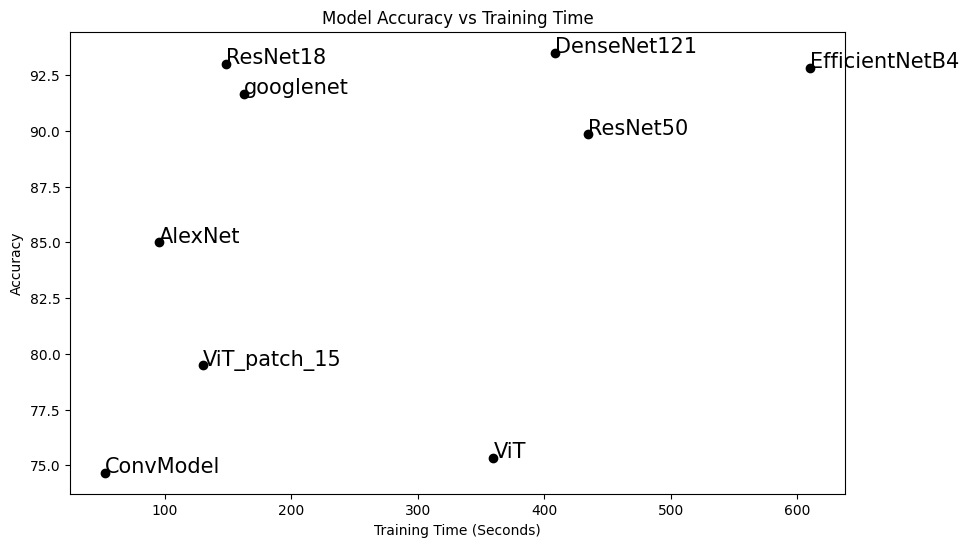

In [ ]:
model_names = []
training_durations = []
model_accuracies = []

for mds in existing_model_list:
    for md in mds:
        model_names.append(md['name'])
        start_time = datetime.datetime.fromisoformat(md['traning_times'][0])
        end_time = datetime.datetime.fromisoformat(md['traning_times'][-1])
        duration = end_time - start_time
        total_seconds = round(duration.total_seconds(),1)
        training_durations.append(total_seconds)
        model_accuracies.append(md['test_accuracy'])

plt.figure(figsize=(10, 6))
plt.scatter(training_durations, model_accuracies, color='black')

for i, model_name in enumerate(model_names):
    plt.annotate(model_name, (training_durations[i], model_accuracies[i]), fontsize=15)

plt.xlabel('Training Time (Seconds)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Training Time')

plt.show()